<a href="https://colab.research.google.com/github/Vivek-23-Titan/Crack-Detection-YOLOv4/blob/master/Crack_Detection_YOLOv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clone the underlying YOLOv4 repository

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 14073 (delta 34), reused 28 (delta 13), pack-reused 14000
Receiving objects: 100% (14073/14073), 12.82 MiB | 7.34 MiB/s, done.
Resolving deltas: 100% (9556/9556), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

#Define Helper Functions.

These three functions are helper functions that will allow you to show the image in your Colab Notebook after running your detections, as well as upload and download images to and from your Cloud VM.

In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(10, 6)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

#Link Drive to access the Dataset

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive

In [ ]:
%cd /content/darknet/

/content/darknet


In [ ]:
# this is where my datasets are stored within my Google Drive (I created a yolov4 folder to store all important files for custom training) 
!ls /mydrive/CV_YOLOv4_Cracks/

backup	  generate_test.py   images1.txt  obj.data   obj.zip   v1
backupv2  generate_train.py  images.txt   obj.names  test.zip  yolov4-obj.cfg


In [ ]:
# copy over both datasets into the root directory of the Colab VM (comment out test.zip if you are not using a validation dataset)
!cp /mydrive/CV_YOLOv4_Cracks/obj.zip ../
!cp /mydrive/CV_YOLOv4_Cracks/test.zip ../

##Dataset is split into training and validation/test set with approximately 75:25 ratio.
##The training data consists of 43 images(data/obj) and test data(data/test) consists of 14 images.

In [ ]:
# unzip the datasets and their contents so that they are now in /darknet/data/ folder
!unzip ../obj.zip -d data/
!unzip ../test.zip -d data/

#Configuring Files for Training
This step involves properly configuring custom .cfg, obj.data, obj.names, train txt and test.txt files.

In [ ]:
%cd /content/darknet/

/content/darknet


In [ ]:
# download cfg to google drive and change its name
#!cp cfg/yolov4-custom.cfg /mydrive/CV_YOLOv4_Cracks/yolov4-obj.cfg

In [ ]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /mydrive/CV_YOLOv4_Cracks/yolov4-obj.cfg ./cfg

In [ ]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /mydrive/CV_YOLOv4_Cracks/obj.names ./data
!cp /mydrive/CV_YOLOv4_Cracks/obj.data  ./data

In [ ]:
# upload the generate_train.py and generate_test.py script to cloud VM from Google Drive
!cp /mydrive/CV_YOLOv4_Cracks/generate_train.py ./
!cp /mydrive/CV_YOLOv4_Cracks/generate_test.py ./

Now simply run both scripts to do the work for you of generating the two txt files.

In [ ]:
!python generate_train.py
!python generate_test.py

In [ ]:
# verify that the newly generated train.txt and test.txt can be seen in our darknet/data folder
!ls data/

9k.tree     giraffe.jpg		      labels		person.jpg  voc.names
coco9k.map  goal.txt		      obj		scream.jpg
coco.names  horses.jpg		      obj.data		test
dog.jpg     imagenet.labels.list      obj.names		test.txt
eagle.jpg   imagenet.shortnames.list  openimages.names	train.txt


#Download pre-trained weights for the convolutional layers.

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

#Train Custom Object Detector

In [ ]:
# train your custom detector! (uncomment %%capture below if you run into memory issues or your Colab is crashing)
#%%capture
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg yolov4.conv.137 -dont_show -map

##History of average loss vs. iterations.

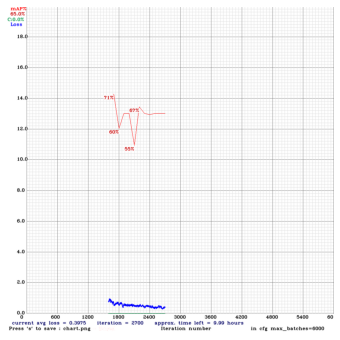

In [ ]:
# show chart.png of how custom object detector did with training
imShow('chart.png')

In [ ]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=1/batch=64/' yolov4-obj.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' yolov4-obj.cfg
%cd ..

/content/darknet/cfg
/content/darknet


In [ ]:
# kick off training from where it last saved
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/yolov4-obj_last.weights -dont_show -map

#Checking the Mean Average Precision (mAP) of Model

In [ ]:
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x 

# Results of Custom Object Detector

In [ ]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj.cfg
%cd ..

/content/darknet/cfg
/content/darknet


##Bullseye

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights /content/darknet/data/test/21.jpg -thresh 0.25

Test Image: 21.jpg


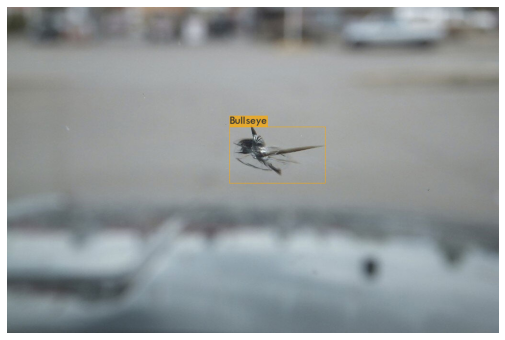

In [ ]:
print('Test Image: 21.jpg')
imShow('predictions.jpg')

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights /content/darknet/data/test/24.jpg -thresh 0.25

Test Image: 24.jpg


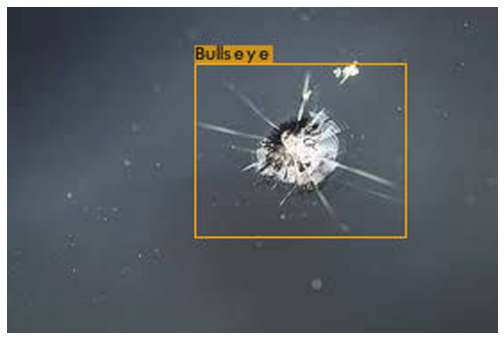

In [ ]:
print('Test Image: 24.jpg')
imShow('predictions.jpg')

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights /content/darknet/data/test/29.jpg -thresh 0.25

Test Image: 29.jpg


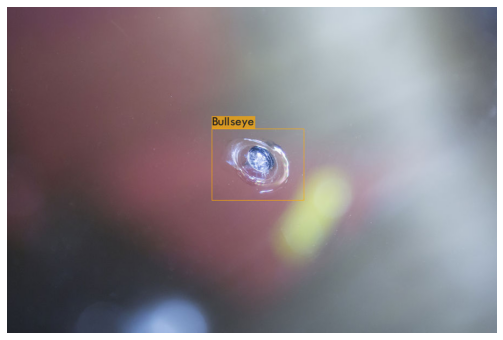

In [ ]:
print('Test Image: 29.jpg')
imShow('predictions.jpg')

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights /content/darknet/data/test/33.jpg -thresh 0.25

Test Image: 33.jpg


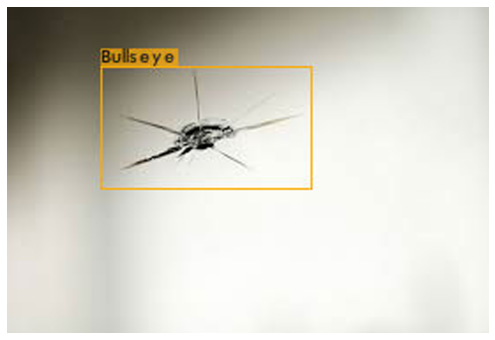

In [ ]:
print('Test Image: 33.jpg')
imShow('predictions.jpg')

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights /content/darknet/data/test/40.jpg -thresh 0.25

Test Image: 40.jpg


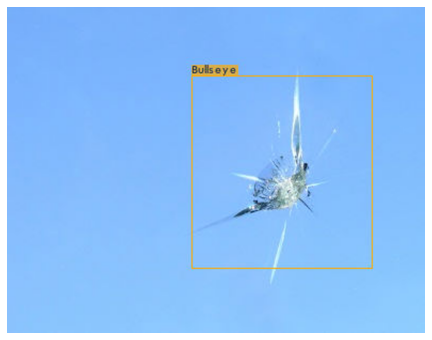

In [ ]:
print('Test Image: 40.jpg')
imShow('predictions.jpg')

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights /content/darknet/data/test/43.jpg -thresh 0.25

Test Image: 43.jpg


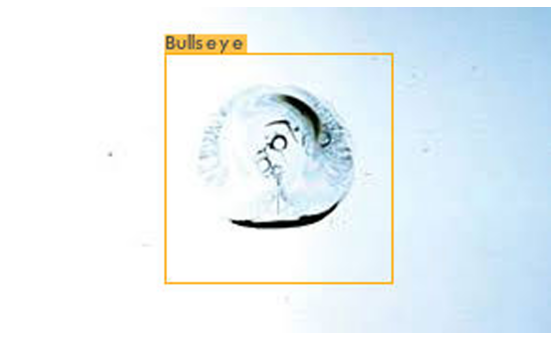

In [ ]:
print('Test Image: 43.jpg')
imShow('predictions.jpg')

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights /content/darknet/data/test/46.jpg -thresh 0.25

Test Image: 46.jpg


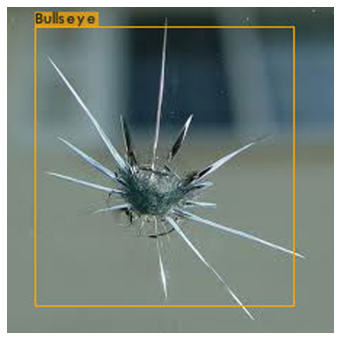

In [ ]:
print('Test Image: 46.jpg')
imShow('predictions.jpg')

##Cracks

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights /content/darknet/data/test/49.jpg -thresh 0.25

Test Image: 49.jpg


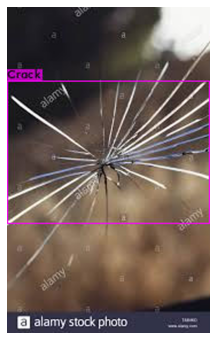

In [ ]:
print('Test Image: 49.jpg')
imShow('predictions.jpg')

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights /content/darknet/data/test/50.jpg -thresh 0.25

Test Image: 50.jpg


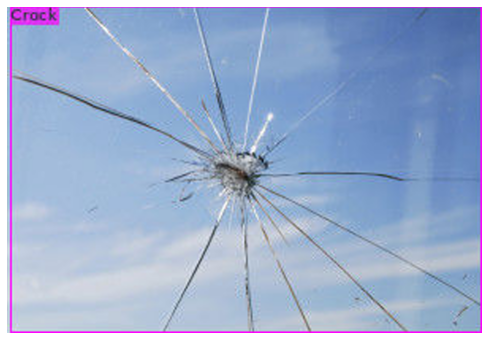

In [ ]:
print('Test Image: 50.jpg')
imShow('predictions.jpg')

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights /content/darknet/data/test/57.jpg -thresh 0.25

Test Image: 57.jpg


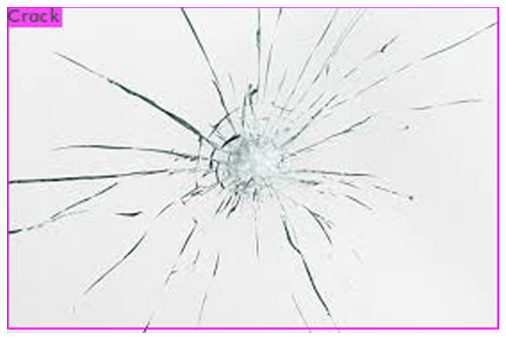

In [ ]:
print('Test Image: 57.jpg')
imShow('predictions.jpg')

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights /content/darknet/data/test/scratch1.jpg -thresh 0.25

Test Image: scratch1.jpg


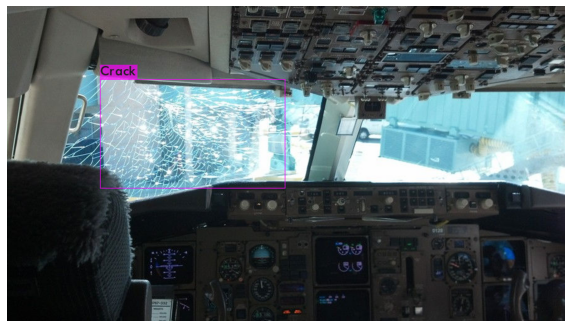

In [ ]:
print('Test Image: scratch1.jpg')
imShow('predictions.jpg')

##Scratches

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights /content/darknet/data/test/52.jpg -thresh 0.25

Test Image: 52.jpg


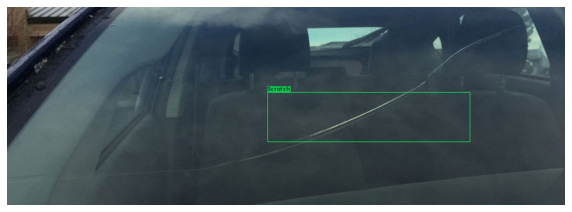

In [ ]:
print('Test Image: 52.jpg')
imShow('predictions.jpg')

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights /content/darknet/data/test/55.jpg -thresh 0.25

Test Image: 55.jpg


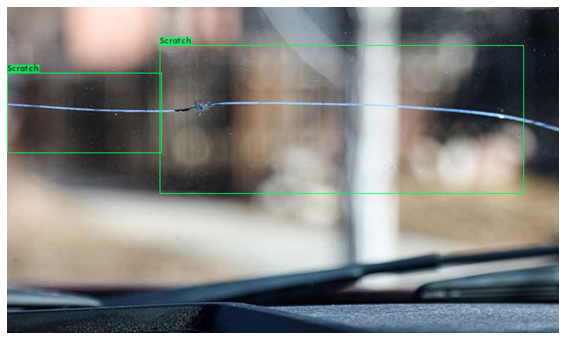

In [ ]:
print('Test Image: 55.jpg')
imShow('predictions.jpg')

##To store the results in a text file

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/CV_YOLOv4_Cracks/backup/69_65_yolov4-obj_best.weights -ext_output < /content/darknet/data/test.txt > result.txt

In [ ]:
download('result.txt')